In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.utils as utils

# Importing Data

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_valid = X_train[:10000,...]
y_valid = y_train[:10000]

X_train = X_train[10000:,...]
y_train = y_train[10000:]

In [5]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(y_valid)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

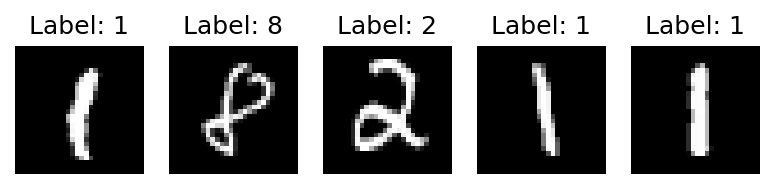

In [6]:
num_images_to_show = 5
random_indices = np.random.randint(0, len(X_train), num_images_to_show)
plt.figure(dpi=150)

# Plotting the images
for i, idx in enumerate(random_indices, 1):
    plt.subplot(1, num_images_to_show, i)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.show()

In [7]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss'])
results

,Model,Accuracy,Loss


# Dropout NN + Max Norm (ReLu, 1024)

In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
net = nn.Sequential(
    OrderedDict([
        ('dropout1', nn.Dropout(0.2)),
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(784, 1024)),
        ('relu1', nn.ReLU()),
        ('dropout2', nn.Dropout(0.5)),  
        ('linear2', nn.Linear(1024, 1024)),  
        ('relu2', nn.ReLU()),
        ('dropout3', nn.Dropout(0.5)),
        ('linear3', nn.Linear(1024, 1024)),  
        ('relu3', nn.ReLU()),
        ('dropout4', nn.Dropout(0.5)), 
        ('linear4', nn.Linear(1024, 10)),  
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.5)


train_loss_list4 = list()
train_acc_list4 = list()
valid_loss_list4 = list()
valid_acc_list4 = list()

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)


In [10]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (dropout1): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)

In [11]:
num_epochs = 100
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply max norm constraint to the gradients
        max_norm = 1.0  # Set your desired max norm value
        for name, param in net.named_parameters():
            if 'weight' in name:
                utils.clip_grad_norm_(param, max_norm)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    
    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = net(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list4.append(train_loss)
    train_acc_list4.append(train_accuracy)
    valid_loss_list4.append(valid_loss)
    valid_acc_list4.append(valid_accuracy)
    
    if epoch%20==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

Epoch 1/100, Train Loss: 1.2566, Train Acc: 0.7173, Valid Loss: 0.2708, Valid Acc: 0.9289
Epoch 21/100, Train Loss: 0.2258, Train Acc: 0.9453, Valid Loss: 0.1194, Valid Acc: 0.9675
Epoch 41/100, Train Loss: 0.1873, Train Acc: 0.9582, Valid Loss: 0.1280, Valid Acc: 0.9739
Epoch 61/100, Train Loss: 0.1777, Train Acc: 0.9628, Valid Loss: 0.1253, Valid Acc: 0.9736
Epoch 81/100, Train Loss: 0.1740, Train Acc: 0.9663, Valid Loss: 0.1500, Valid Acc: 0.9737
Finished Training


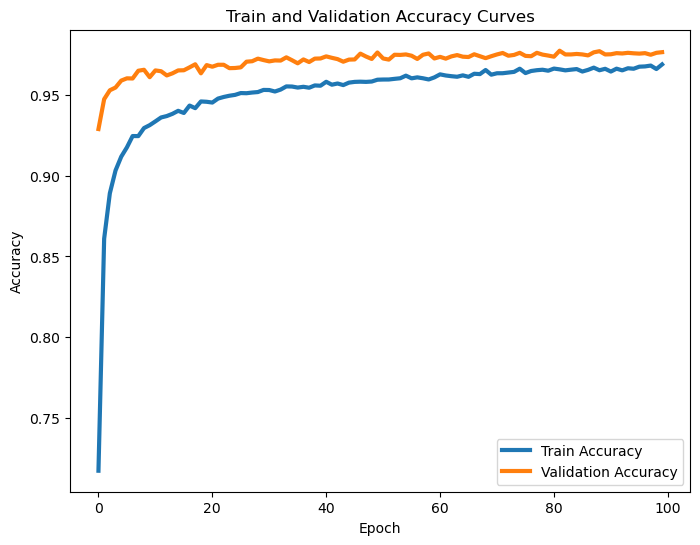

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list4, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list4, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

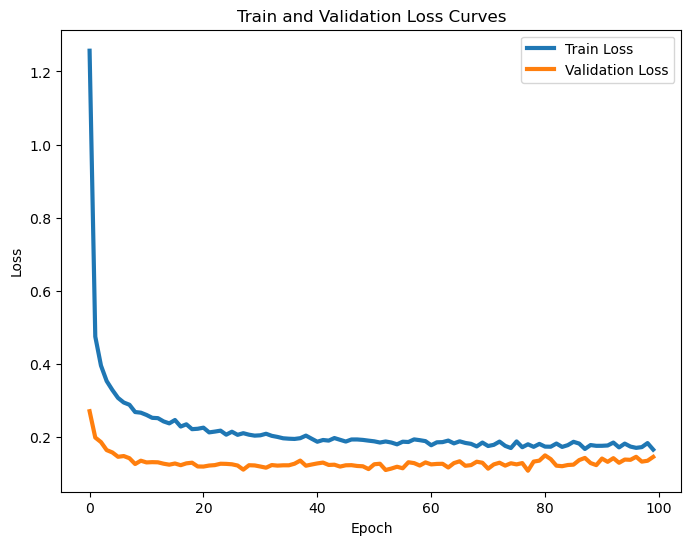

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list4, label='Train Loss', lw=3)
plt.plot(valid_loss_list4, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [14]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



Test Loss: 0.1203, Test Acc: 0.9785


In [15]:
results_temp = pd.DataFrame(
    [[
        'Dropout NN + Max (ReLu, 1024)',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

,Model,Accuracy,Loss
0,"Dropout NN + Max (ReLu, 1024)",0.9785,0.120303


In [16]:
data = {
    'Train Loss': train_loss_list4,
    'Train Accuracy': train_acc_list4,
    'Validation Loss': valid_loss_list4,
    'Validation Accuracy': valid_acc_list4
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Specify the filename
filename = 'mnist_dropout_max_relu1.csv'

# Write to a CSV file
df.to_csv(filename, index=False)